In [1]:
import torch
import numpy as np
import PIL.Image
import torchvision.transforms.functional as T
from torchvision.utils import make_grid

from TranSalNet_Res import TranSalNet

TARGET_H, TARGET_W = 288, 384
device = torch.device("cuda:4")

Load ResNet-based model and pre-trained parameters.

In [2]:
model = TranSalNet()
model.load_state_dict(torch.load('pretrained_models/TranSalNet_Res.pth', map_location='cpu'))
model.to(device) 
model.eval();

(3, 512, 768) (1, 512, 768)


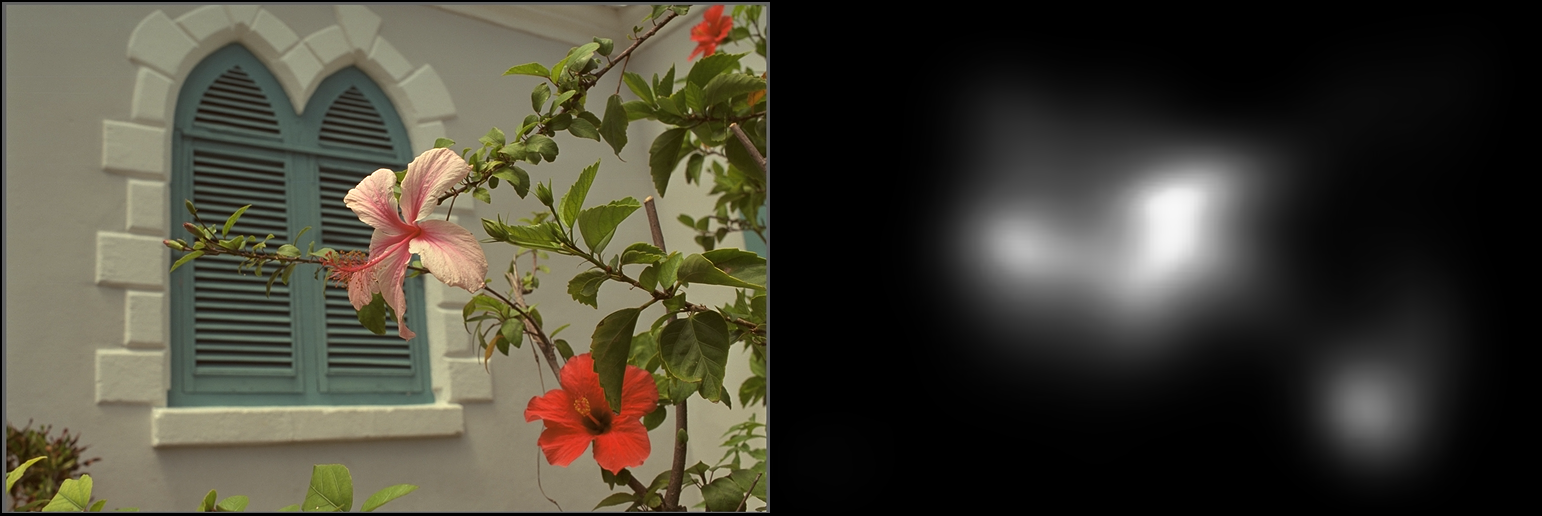

(3, 1024, 683) (1, 1024, 683)


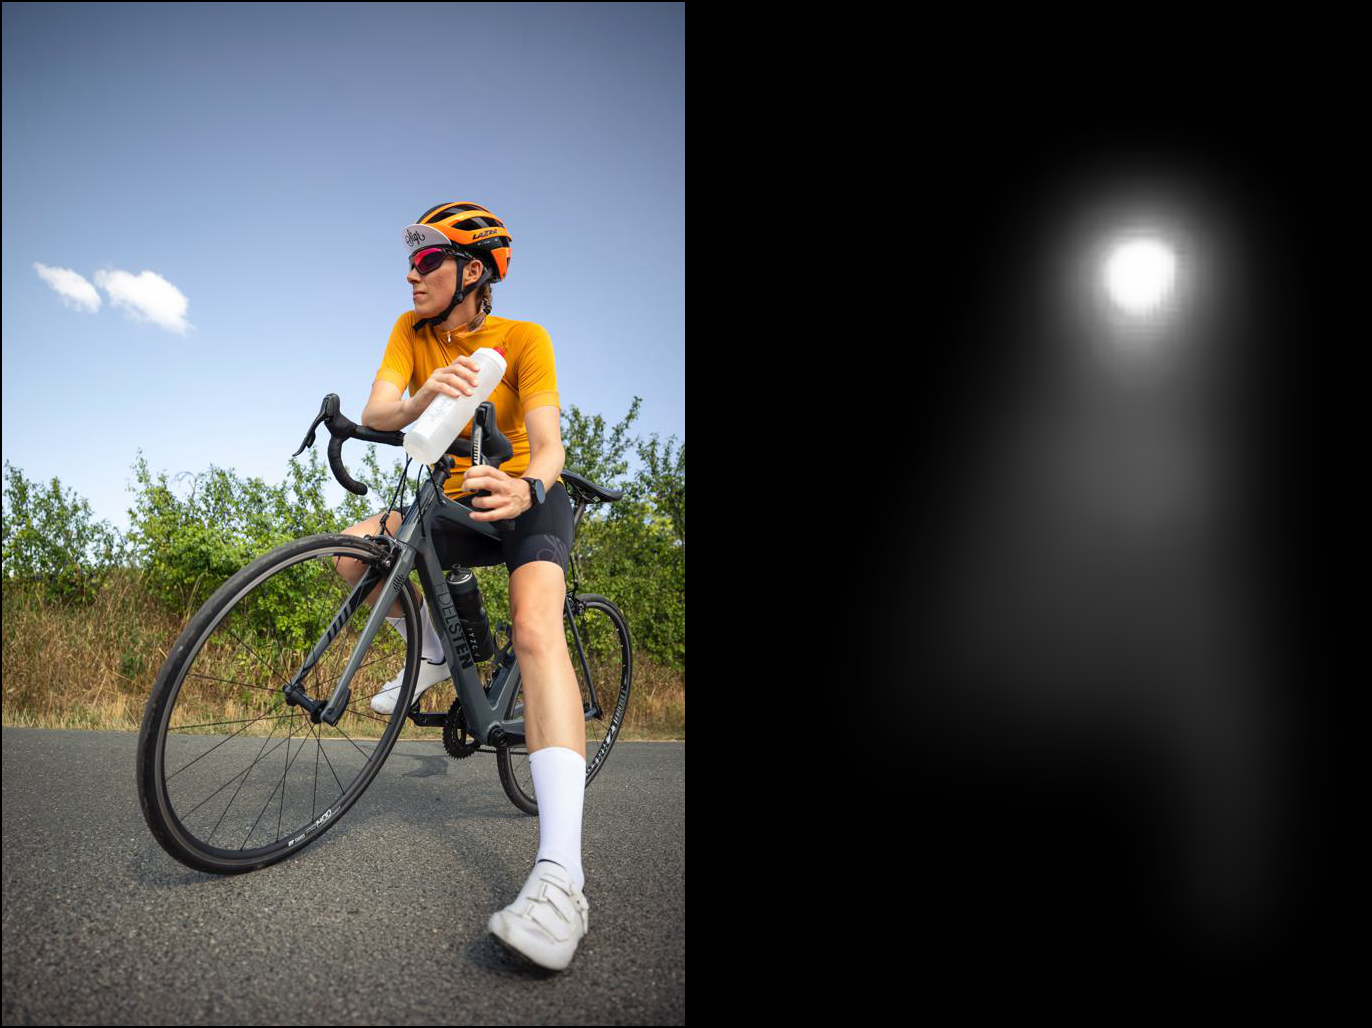

(3, 1024, 683) (1, 1024, 683)


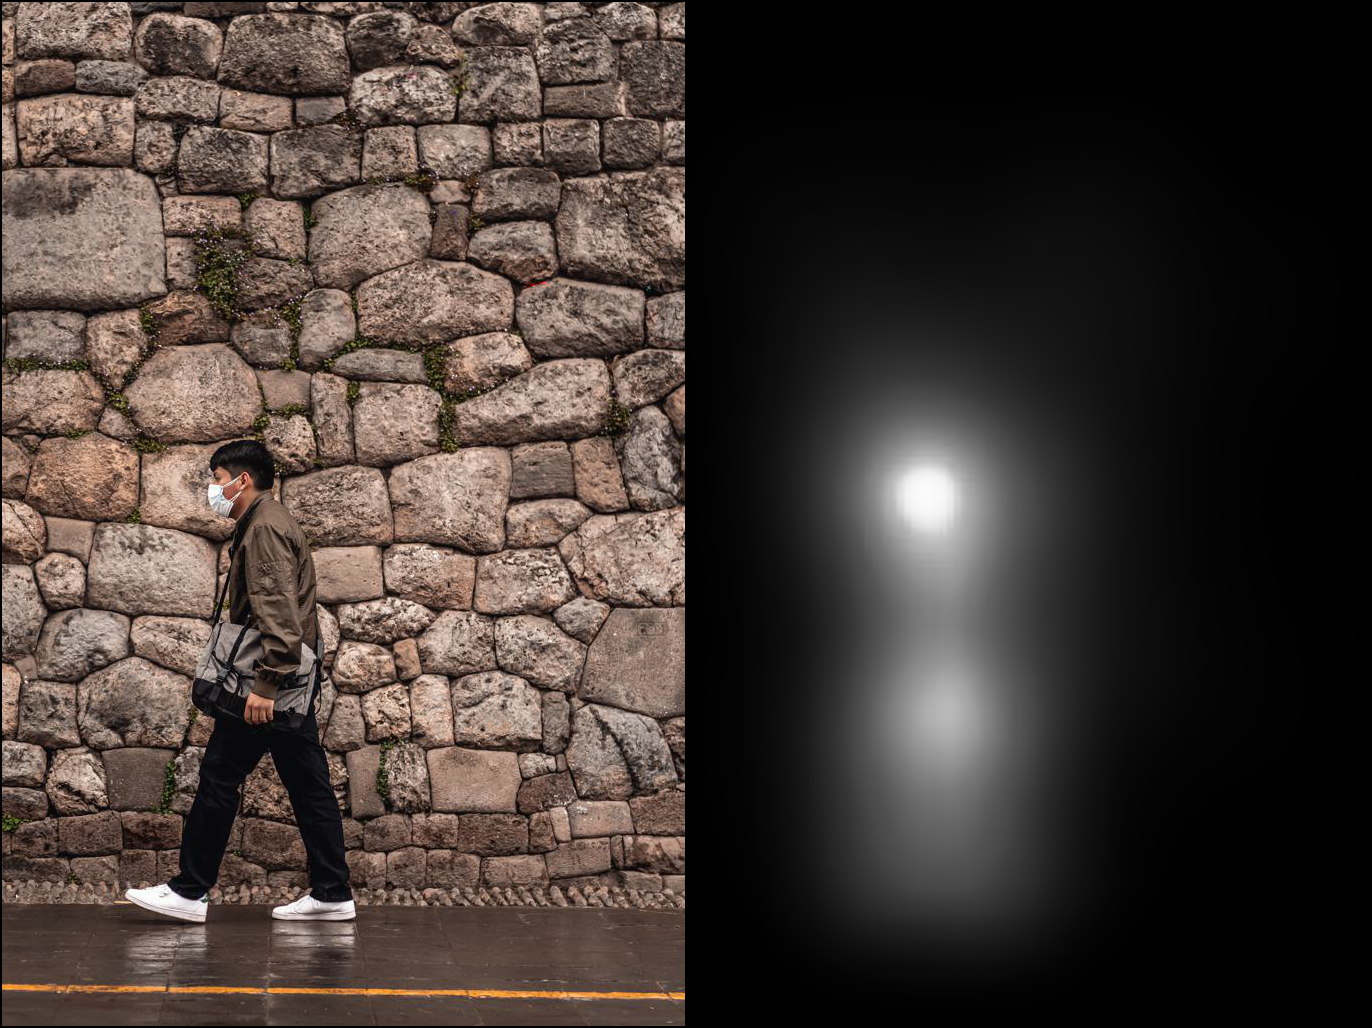

In [3]:
def preprocess(img: torch.Tensor) -> torch.Tensor:
    H, W = img.shape[-2:]
    ratio = W / H
    
    # Resize
    if TARGET_H * ratio <= TARGET_W:
        img = T.resize(img, (TARGET_H, int(TARGET_H * ratio)))
    else:
        img = T.resize(img, (int(TARGET_W / ratio), TARGET_W))
    h, w = img.shape[-2:]

    # Pad
    pad = (
        int(np.ceil((TARGET_W - w) / 2)), # left
        int(np.ceil((TARGET_H - h) / 2)), # top
        int(np.floor((TARGET_W - w) / 2)), # right
        int(np.floor((TARGET_H - h) / 2)), # bottom
    )
    img = T.pad(img, pad)
    
    return img, (H, W), pad

def postprocess(img, HW, pad):
    h, w = img.shape[-2:]
    left, top, right, bottom = pad
    img = img[..., top:h-bottom, left:w-right]
    img = T.resize(img, HW)
    return img

def predict_and_show(img: str):
    with open(img, 'rb') as f:
        img = PIL.Image.open(f).convert('RGB')

    img = T.to_tensor(img)
    input, HW, pad = preprocess(img)
    input = input.to(device)
    pred = model(input[None, ...])[0]
    pred = postprocess(pred, HW, pad)
    
    print(tuple(img.shape), tuple(pred.shape))
    display(T.to_pil_image(make_grid([img, pred.cpu().expand(3, -1, -1)])))

predict_and_show('example/kodak_flower.png')
predict_and_show('example/unsplash_orange_biker.jpg')
predict_and_show('example/person_walking.jpg')